In [36]:
import torch.nn.functional as F
import random

In [37]:
# Install packages if needed
#!pip install torch torchvision numpy Pillow tqdm

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import glob
import os
from tqdm import tqdm



In [38]:
class ResidualConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualConv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        )
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0)

    def forward(self, x):
        return self.conv_block(x) + self.skip(x)

class Up_ResidualConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up_ResidualConv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        )
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) #difference in up residual conv and residual conv

    def forward(self, x):
        return self.conv_block(x) + self.skip(x)



class Upsample(nn.Module):
    def __init__(self,image):
    #def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        
        self.upsampled_image = F.interpolate(image,scale_factor=2, mode='bicubic', align_corners=True)


    def forward(self, x):
        return self.upsample(x)

class ResUnet(nn.Module):
    def __init__(self, channel=3, filters=[64, 128, 256, 512]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=channel, out_channels=filters[0], kernel_size=3, padding=1 ,stride=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters[0], out_channels=filters[0], kernel_size=3, padding=1,stride=1),
        )
        self.input_skip = nn.Conv2d(channel, filters[0], kernel_size=3, padding=1, stride=1)

        self.residual_conv_1 = ResidualConv(filters[0], filters[1])
        self.residual_conv_2 = ResidualConv(filters[1], filters[2])

        self.bridge = ResidualConv(filters[2], filters[3])

        self.up_residual_conv1 = Up_ResidualConv(filters[3] + filters[2], filters[2])

        self.up_residual_conv2 = Up_ResidualConv(filters[2] + filters[1], filters[1])

        self.up_residual_conv3 = Up_ResidualConv(filters[1] + filters[0], filters[0])

        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=filters[0],out_channels= 1, kernel_size=1, padding=0, stride=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        x4 = self.bridge(x3)
        #x4 = self.upsample_1(x4)
        x4 = F.interpolate(x4,scale_factor=2, mode='bicubic', align_corners=True)
        x5 = torch.cat([x4, x3], dim=1)
        x6 = self.up_residual_conv1(x5)
        #x6 = self.upsample_2(x6)
        x6 = F.interpolate(x6,scale_factor=2, mode='bicubic', align_corners=True)
        x7 = torch.cat([x6, x2], dim=1)
        x8 = self.up_residual_conv2(x7)
        #x8 = self.upsample_3(x8)
        x8 = F.interpolate(x8,scale_factor=2, mode='bicubic', align_corners=True)
        x9 = torch.cat([x8, x1], dim=1)
        x10 = self.up_residual_conv3(x9)
        output = self.output_layer(x10)
        return output



In [39]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [40]:
from torchinfo import summary

# Instantiate the model
model = ResUnet(channel=3, filters=[64, 128, 256, 512])

# Print the model summary with detailed layer information
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResUnet                                  [1, 3, 224, 224]          [1, 1, 224, 224]          --                        --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 64, 224, 224]         --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 224, 224]         1,792                     [3, 3]                    89,915,392
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         [1, 64, 224, 224]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         [1, 64, 224, 224]         --                        --                        --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         [1, 64, 224, 224]         36,

In [41]:
class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir,is_for_train=0 ,transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = glob.glob(f"{image_dir}/*.png")
        self.is_for_train= is_for_train

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = img_path.replace(self.image_dir, self.mask_dir)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 'L' Grayscale for mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        if self.is_for_train==0:
            return image, mask,img_path,mask_path
        else:
            return image, mask

In [42]:
#Generating Samples
def crop_random_patches(image_path, mask_path, save_dir,iteration, crop_size=(224, 224), num_patches=10):
    # Load the image and mask
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # grayscale for the mask

    # Ensure output directories exist
    os.makedirs(f"{save_dir}/images", exist_ok=True)
    os.makedirs(f"{save_dir}/masks", exist_ok=True)

    width, height = image.size
    crop_width, crop_height = crop_size

    patches = []
    for i in range(num_patches):
        # Randomly select the top-left corner for the crop
        x = random.randint(0, width - crop_width)
        y = random.randint(0, height - crop_height)

        # Crop both the image and mask
        image_patch = image.crop((x, y, x + crop_width, y + crop_height))
        mask_patch = mask.crop((x, y, x + crop_width, y + crop_height))

        # Save the patches
        image_patch.save(f"{save_dir}/images/patch_{i+(iteration*num_patches)}.png")
        mask_patch.save(f"{save_dir}/masks/patch_{i+(iteration*num_patches)}.png")

        patches.append((image_patch, mask_patch))

    return patches

img_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\train\input"
mask_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\train\output"
road_dataset=RoadDataset(img_dir,mask_dir)
print(road_dataset.__len__())
train_data =[]
for i in range(road_dataset.__len__()):
    print(f"Iteration {i}")
    image_path,mask_path = road_dataset.__getitem__(i)[2],road_dataset.__getitem__(i)[3]
    savedir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\train\crop"
    num_patch = 10
    patches = crop_random_patches(image_path, mask_path,iteration=i, crop_size=(224, 224), num_patches=num_patch, save_dir=savedir)
    print(f"Generated {len(patches)} patches of size 224x224 ")

20
Iteration 0
Generated 10 patches of size 224x224 
Iteration 1
Generated 10 patches of size 224x224 
Iteration 2
Generated 10 patches of size 224x224 
Iteration 3
Generated 10 patches of size 224x224 
Iteration 4
Generated 10 patches of size 224x224 
Iteration 5
Generated 10 patches of size 224x224 
Iteration 6
Generated 10 patches of size 224x224 
Iteration 7
Generated 10 patches of size 224x224 
Iteration 8
Generated 10 patches of size 224x224 
Iteration 9
Generated 10 patches of size 224x224 
Iteration 10
Generated 10 patches of size 224x224 
Iteration 11
Generated 10 patches of size 224x224 
Iteration 12
Generated 10 patches of size 224x224 
Iteration 13
Generated 10 patches of size 224x224 
Iteration 14
Generated 10 patches of size 224x224 
Iteration 15
Generated 10 patches of size 224x224 
Iteration 16
Generated 10 patches of size 224x224 
Iteration 17
Generated 10 patches of size 224x224 
Iteration 18
Generated 10 patches of size 224x224 
Iteration 19
Generated 10 patches of s

In [43]:
import sys
img_dir=r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\train\crop\images"
mask_dir=r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\train\crop\masks"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
road_dataset=RoadDataset(img_dir,mask_dir,is_for_train=1,transform=transform)

train_loader = DataLoader(road_dataset, batch_size=1, shuffle=True)
print(len(train_loader))

200


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUnet(channel=3).to(device)
criterion=nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, masks in tqdm(loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader)}")

train(model, train_loader, optimizer, criterion, epochs=15)


  0%|▍                                                                                 | 1/200 [00:00<00:22,  8.72it/s]

Epoch 1/15, Loss: 0.1245457890839316


  0%|▍                                                                                 | 1/200 [00:00<00:21,  9.42it/s]

Epoch 2/15, Loss: 0.1081751118565444


  0%|▍                                                                                 | 1/200 [00:00<00:23,  8.47it/s]

Epoch 3/15, Loss: 0.09390635881340131


  0%|▍                                                                                 | 1/200 [00:00<00:22,  8.78it/s]

Epoch 4/15, Loss: 0.0907109012294677


  0%|▍                                                                                 | 1/200 [00:00<00:22,  8.70it/s]

Epoch 5/15, Loss: 0.08945118655916304


  0%|▍                                                                                 | 1/200 [00:00<00:22,  8.69it/s]

Epoch 6/15, Loss: 0.08488825493550393


  0%|▍                                                                                 | 1/200 [00:00<00:21,  9.11it/s]

Epoch 7/15, Loss: 0.08867240616120398


  0%|▍                                                                                 | 1/200 [00:00<00:23,  8.52it/s]

Epoch 8/15, Loss: 0.08467835998395458


  0%|▍                                                                                 | 1/200 [00:00<00:21,  9.27it/s]

Epoch 9/15, Loss: 0.084144711564295


  0%|▍                                                                                 | 1/200 [00:00<00:23,  8.49it/s]

Epoch 10/15, Loss: 0.08292160868644714


  0%|▍                                                                                 | 1/200 [00:00<00:21,  9.25it/s]

Epoch 11/15, Loss: 0.0802143858850468


  0%|▍                                                                                 | 1/200 [00:00<00:21,  9.29it/s]

Epoch 12/15, Loss: 0.07889265462872572


  0%|▍                                                                                 | 1/200 [00:00<00:23,  8.44it/s]

Epoch 13/15, Loss: 0.08010362427041401


  0%|▍                                                                                 | 1/200 [00:00<00:23,  8.54it/s]

Epoch 14/15, Loss: 0.07837481925438623


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.55it/s]

Epoch 15/15, Loss: 0.07737993619579356


In [45]:
img_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\input"
mask_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\output"
road_dataset=RoadDataset(img_dir,mask_dir)
print(road_dataset.__len__())
train_data =[]
for i in range(road_dataset.__len__()):
    print(f"Iteration {i}")
    image_path,mask_path = road_dataset.__getitem__(i)[2],road_dataset.__getitem__(i)[3]
    savedir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\crop"
    num_patch = 10
    patches = crop_random_patches(image_path, mask_path,iteration=i, crop_size=(224, 224), num_patches=num_patch, save_dir=savedir)
    print(f"Generated {len(patches)} patches of size 224x224 ")    

5
Iteration 0
Generated 10 patches of size 224x224 
Iteration 1
Generated 10 patches of size 224x224 
Iteration 2
Generated 10 patches of size 224x224 
Iteration 3
Generated 10 patches of size 224x224 
Iteration 4
Generated 10 patches of size 224x224 


In [46]:
def predict(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device) #Add extra dimension to image for setting the batch size
    with torch.no_grad(): #Disables gradient calculation to improve computation and memory usage
        output = model(image)
        output = output.squeeze().cpu().numpy() #Remove extra dimension of batch size to make it easier to work
        #moves the output tensor to the CPU necessary if you plan to perform further operations or visualize output on a device 
        #that doesn’t support GPU tensors
        #converts the tensor to a NumPy array, which is easier to manipulate and visualize in Python.        
    return output

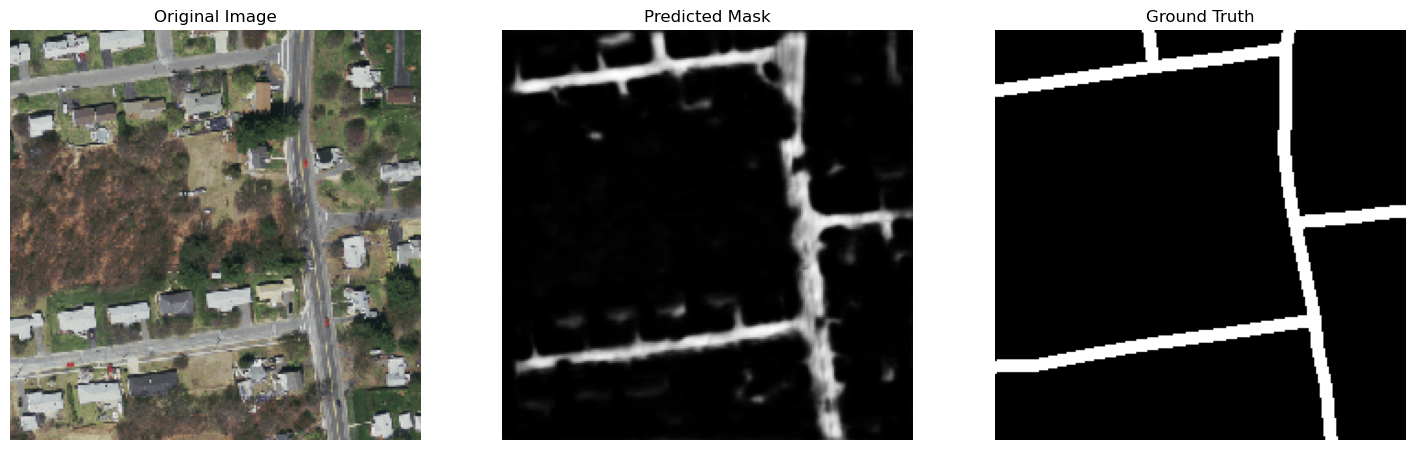

In [52]:
import matplotlib.pyplot as plt
img_dir= r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\crop\images\patch_28.png"
mask_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\crop\masks\patch_28.png"
#Ground truth
ground_truth = Image.open(mask_dir).convert("RGB")
# Assuming the output is a mask with values between 0 and 1
output = predict(model,img_dir, transform)

# Load the original image for comparison
original_image = Image.open(img_dir).convert("RGB")

# Plotting the original image, predicted mask, and ground truth side by side
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.imshow(output, cmap='gray')  # Use 'gray' for grayscale mask visualization
plt.title("Predicted Mask")
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.imshow(ground_truth, cmap='gray')  # 'gray' is often useful for binary masks
plt.title("Ground Truth")
plt.axis("off")

plt.show()



In [53]:
#Evaluation 
import torch
import numpy as np
#from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score

def relaxed_precision_recall(model, val_loader, device, threshold=0.5, relaxation_kernel_size=3):
    model.eval()
    precisions = []
    recalls = []
    iteration=0
    with torch.no_grad():
        for images, masks in val_loader:
            iteration=iteration+1
            
            images = images.to(device)
            masks = masks.to(device)
            
            if images.dim() == 3: 
                # [batch_size, height, width]
                images = images.unsqueeze(0)  # Add channel dimension to make it [batch_size, 1, height, width]
            
        
            # Forward pass
            outputs = model(images)
            preds = outputs
            
            
            # Apply relaxed kernel
            relaxation_kernel = torch.ones((1, 1, relaxation_kernel_size, relaxation_kernel_size), device=device)
            relaxed_masks = torch.nn.functional.conv2d(masks, relaxation_kernel, padding=relaxation_kernel_size // 2,stride=1)
            relaxed_preds = torch.nn.functional.conv2d(preds, relaxation_kernel, padding=relaxation_kernel_size // 2,stride=1)
            
            # Convert relaxed masks and preds to binary (0/1) based on any overlap within the relaxation window
            relaxed_masks = (relaxed_masks > 0).float()
            relaxed_preds = (relaxed_preds > 0).float()
            
            # Calculate precision and recall for each image in the batch
            for pred, relaxed_mask in zip(relaxed_preds, relaxed_masks):
                
                pred_flat = pred.view(-1).cpu().numpy()
                mask_flat = relaxed_mask.view(-1).cpu().numpy()
                
                precision = precision_score(mask_flat, pred_flat)
                recall = recall_score(mask_flat, pred_flat)
                
                precisions.append(precision)
                recalls.append(recall)
                
            print(f"Iteration {iteration}: {precision} and {recall}")
                
            
    # Average precision and recall over the validation set
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    print(f"Relaxed Precision: {avg_precision:.4f}, Relaxed Recall: {avg_recall:.4f}")
    return avg_precision, avg_recall

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\crop\images"
mask_dir = r"C:\Users\ltcol\OneDrive\Desktop\IIT Indore sem 1\ASP Proj\ResUnet-master\ResUnet-master\validation\crop\masks"
val_loader= RoadDataset(img_dir,mask_dir,1,transform)
avg_precision, avg_recall = relaxed_precision_recall(model, val_loader, device, threshold=0.5, relaxation_kernel_size=3)


Iteration 1: 0.051638233418367346 and 1.0
Iteration 2: 0.13596141581632654 and 1.0
Iteration 3: 0.08238998724489796 and 1.0
Iteration 4: 0.17259247448979592 and 1.0
Iteration 5: 0.1868622448979592 and 1.0
Iteration 6: 0.07049186862244898 and 1.0
Iteration 7: 0.2022281568877551 and 1.0
Iteration 8: 0.2225765306122449 and 1.0
Iteration 9: 0.1787906568877551 and 1.0
Iteration 10: 0.024952168367346938 and 1.0
Iteration 11: 0.3688217474489796 and 1.0
Iteration 12: 0.31050701530612246 and 1.0
Iteration 13: 0.046595982142857144 and 1.0
Iteration 14: 0.08248963647959184 and 1.0
Iteration 15: 0.11033163265306123 and 1.0
Iteration 16: 0.05247528698979592 and 1.0
Iteration 17: 0.06556919642857142 and 1.0
Iteration 18: 0.1143375318877551 and 1.0
Iteration 19: 0.16011639030612246 and 1.0
Iteration 20: 0.07944036989795919 and 1.0
Iteration 21: 0.09815449617346939 and 1.0
Iteration 22: 0.11451690051020408 and 1.0
Iteration 23: 0.10052614795918367 and 1.0
Iteration 24: 0.10357541454081633 and 1.0
Iter

C:\Users\ltcol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ltcol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 26: 0.0 and 0.0
Iteration 27: 0.0 and 0.0
Iteration 28: 0.06513073979591837 and 1.0
Iteration 29: 0.03419961734693878 and 1.0
Iteration 30: 0.008310746173469387 and 1.0
Iteration 31: 0.013333067602040817 and 1.0
Iteration 32: 0.022520727040816327 and 1.0
Iteration 33: 0.0 and 0.0
Iteration 34: 0.0 and 0.0


C:\Users\ltcol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ltcol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 35: 0.06712372448979592 and 1.0
Iteration 36: 0.024613360969387755 and 1.0
Iteration 37: 0.15915975765306123 and 1.0
Iteration 38: 0.1844905931122449 and 1.0
Iteration 39: 0.11563297193877552 and 1.0
Iteration 40: 0.15563217474489796 and 1.0
Iteration 41: 0.2471500318877551 and 1.0
Iteration 42: 0.21342873086734693 and 1.0
Iteration 43: 0.049505739795918366 and 1.0


C:\Users\ltcol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 44: 0.0 and 0.0
Iteration 45: 0.2722018494897959 and 1.0
Iteration 46: 0.006636639030612245 and 1.0
Iteration 47: 0.09873246173469388 and 1.0
Iteration 48: 0.00665656887755102 and 1.0
Iteration 49: 0.04099569515306122 and 1.0
Iteration 50: 0.10909598214285714 and 1.0
Relaxed Precision: 0.1019, Relaxed Recall: 0.9000
